# <b>DarkVec: Automatic Analysis of Darknet Trafficwith Word Embeddings</b>
## <b>Unsupervised Approach: Clustering Algorithms</b>

___
# <b>Table of Content</b> <a id="toc_"></a>

* [<b>Clustering Methodology</b>](#clustering)
    * [DBSCAN](#dbscan)
    * [Hierarchical Agglomerative Clustering (HAC)](#hac)
    * [$k$-Nearest-Neighbors Graph](#knnG)
* [<b>Cluster Inspection</b>](#ci)
    * [Clusters Ranking](#shplot)
    * [Censys (Sub-clusters)](#censysC)
    * [Shadowserver (Discovered scanner)](#ShadowserverC)
    * [New Unknown](#new)
    * [New Unknown2](#new2)
    * [Unknown1 (NetBIOS scanner)](#unk1)
    * [Unknown2 (SMTP scanner)](#unk2)
    * [Unknown3 (SMB scanner)](#unk3)
    * [Unknown4 (Mirai-like)](#unk4)
    * [Unknown5 (SSH brute-force)](#unk5)
    * [Unknown6 (Massive scanner)](#unk6)
    
   
In this notebook we report all the experiments related to the unsupervised approach. We focus on two experiments:

1) We identify the best clustering algorithm among DBSCAN, Hierarchical Agglomerative Clustering (HAC) and Louvain applied on the k-nearest-neighbor graph. All the clustering algorithms are applied on top of the embeddings generated through the DarkVec model trained over 30 days with the per-service languages, $C=25$, $V=50$.

2) Manual inspection of the best clusters. We extract a brief report of the clusters, the activity patterns scatterplot and the heatmaps of the ports reached by the IPs belonging to the cluster


___
***Note:*** All the code and data we provide are the ones included in the paper. To speed up the notebook execution, by default we trim the files when reading them. Comments on how to run on complete files are provided in the notebook. Note that running the notebook with the complete dataset requires *a PC with significant amount of memory*. 

In [1]:
from config import *
from src.callbacks import *
from src.utils import *
import pandas as pd
import numpy as np
import warnings
import json
from glob import glob
from sklearn.metrics.pairwise import cosine_distances
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering as HAC
from sklearn.metrics import silhouette_score as silhouette
from src.knngraph import *

from pandas.core.common import SettingWithCopyWarning
from pandas.errors import DtypeWarning

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=DtypeWarning)

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import fastplot
from cycler import cycler
plt.rcParams["font.family"] = "serif"

cc = (cycler('color',['k', 'r', 'b', 'g', 'y', 'm', 'c'])+
      cycler('linestyle',['-', '--', '-.', ':', '-', '--', '-.']))

In [3]:
demonstrative = False

In [4]:
darknet = pd.read_csv(f'{DATASETS}/darknet.csv.gz')
darknet.head()

,ts,ip,port,proto,pp,class
0,2021-03-03 05:20:26.686132,165.172.152.128,445,TCP,445/TCP,unknown
1,2021-03-03 05:20:26.691946,158.86.51.237,16523,TCP,16523/TCP,unknown
2,2021-03-03 05:20:26.784749,19.160.222.118,5353,TCP,5353/TCP,unknown
3,2021-03-03 05:20:26.878851,210.105.89.28,7070,TCP,7070/TCP,unknown
4,2021-03-03 05:20:26.895800,194.209.229.65,445,TCP,445/TCP,unknown


In [5]:
dataset = darknet[['ip', 'class']].drop_duplicates()
dataset.head()

,ip,class
0,165.172.152.128,unknown
1,158.86.51.237,unknown
2,19.160.222.118,unknown
3,210.105.89.28,unknown
4,194.209.229.65,unknown


In [6]:
mname = f'service_c25_v100_iter20_ori'
model = load_model(mname)

In [7]:
embeddings = get_scaled_embeddings(dataset, model, mname, False)

In [8]:
embeddings.head()
embeddings.to_csv(f'{DATASETS}/embeddings_ori_full.csv.gz')

# <b>Clustering Methodology</b> <a name="clustering"></a> 


To choose the best clustering algorithm we test DBSCAN, Hierarchical Agglomerative Clustering (HAC) and the Louvain algorithm on the k-nearest-neighbor graph.

In [6]:
embeddings = pd.read_csv(f'{DATASETS}/embeddings_ori_full.csv.gz').set_index('ip')
# embeddings = embeddings[:10000]
embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,class
ip,,,,,,,,,,,,,,,,,,,,,
165.172.152.128,0.079457,-0.670008,0.511122,0.087048,0.429199,1.525271,-0.135815,-0.442024,1.044691,1.167559,...,0.088210,0.074550,1.068204,0.224239,0.425610,0.572906,-0.696130,-1.479688,0.090647,unknown
158.86.51.237,0.930632,0.379677,0.000128,0.412175,-0.164714,0.782282,-0.854538,0.794394,0.972092,1.578473,...,-0.111754,0.473064,0.759226,0.947699,-0.781793,0.242922,0.930971,-0.451807,-0.273634,unknown
19.160.222.118,0.474793,0.968409,-0.203706,-0.747987,0.885297,2.315601,0.582268,-0.120352,0.736157,0.462451,...,0.265739,-0.515515,0.088810,-0.784353,-0.123952,0.462652,-0.692154,0.651599,-1.695924,unknown
210.105.89.28,-0.355059,-0.299265,0.081277,-0.064876,-0.700625,-0.159234,0.534126,-0.117759,-0.403919,0.533277,...,-0.838357,-0.642557,0.068725,-0.588873,0.216381,-0.142521,1.289834,0.287081,-0.299648,unknown
194.209.229.65,-0.137953,-0.800600,1.105164,-0.164053,1.365771,4.177793,-1.281016,-1.183026,3.172929,2.724982,...,1.956693,-0.698113,4.545540,0.718399,1.035515,3.295889,-2.849317,-4.924347,-0.327575,unknown


,ts,port,proto,pp,ts_float,class
ip,,,,,,
8330,1.538325e+09,2323,6,2323/tcp,1.538325e+09,unknown
e5f7,1.538325e+09,58664,6,58664/tcp,1.538325e+09,unknown
cedc,1.538325e+09,3358,6,3358/tcp,1.538325e+09,unknown
8f60,1.538325e+09,60287,6,60287/tcp,1.538325e+09,unknown
00a1,1.538325e+09,47451,6,47451/tcp,1.538325e+09,unknown


### <b>DBSCAN</b> <a name="dbscan"></a> 



Run the DBSCAN on the generated embeddings. Since the algorithm requires in advance the `minPts` and $\epsilon$ parameters, we use the heuristics suggested by the original DBSCAN paper:

* `minPts`$=ln(N)$, where $N$ is the number of samples
* $\epsilon$ fixed through the elbow method on the k-dist plot

In [32]:
X = embeddings[embeddings.columns[:-1]]
dist = cosine_distances(X, X)
eps = elbow_eps(dist, X)
minPts = int(np.log(X.shape[0])-1)
print(f'knee at epsilon = {eps}')
print(f'minPts = {minPts}')

knee at epsilon = 0.00469962137655263
minPts = 8


In [33]:
dbscan = DBSCAN(eps=eps, min_samples=minPts, 
                metric='precomputed', n_jobs=-1)
pred = dbscan.fit_predict(dist)
dbscan_shs = get_shs_df(embeddings, pred)
dbscan_shs.head()

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [17]:
import numpy as np
print(np.mean(dbscan_shs['sh']))

0.04658944889532153


### <b>Hierarchical Agglomerative Clustering (HAC)</b> <a name="hac"></a> 


Run the HAC on the generated embeddings. Since the algorithm requires in advance the number of clusters, we run a heuristic choosing the number of clusters ensuring the highest silhouette value.

In [34]:
shs = []
ncs = []
# for k in range(2, 10):
k = 2
cl = HAC(n_clusters=k, affinity='precomputed', linkage='complete', 
         compute_full_tree=True)
pred = cl.fit_predict(dist)
sh = silhouette(dist, pred, metric='precomputed')
shs.append(sh)
ncs.append(k)

In [35]:
hac = HAC(n_clusters=ncs[np.argmax(shs)], affinity='precomputed', 
          linkage='complete')
pred = hac.fit_predict(dist)
hac_shs = get_shs_df(embeddings, pred)
hac_shs.head()

,sh,C
ip,,
8330,0.048069,0
e5f7,0.024750,1
cedc,0.015478,1
8f60,0.020299,1
00a1,0.061018,0


In [36]:
import numpy as np
print(np.mean(hac_shs['sh']))

0.06532367599656137


### <b>$k$-Nearest-Neighbors Graph</b> <a name="knnG"></a> 


Build a k-nearest-neighbor graph on top of the generated embeddings. We try different $k'$, then by plotting the number of found clusters and modularity we chose the best value.

In [37]:
mods = []
ncs  = []
for kk in range(4, 4):
# for kk in range(1, 3):
    print(f'Running k: {kk}')
    knn = KnnGraph(graph_path=None, k=kk, graph_gen=True,
                   embeddings=embeddings[embeddings.columns[:-1]].to_numpy(), 
                   ips=embeddings.index, labels=embeddings['class'])
    knn.fit_predict()
    mods.append(knn.mod)
    ncs.append(knn.nc)
    
# with open(f'{GRIDSEARCH}/knngraph.json', 'w') as file:
#    file.write(json.dumps({'ncs':ncs, 'mods':mods}))
print(f'Number of clusters for the first 2 tested k: {ncs}')
print(f'Modularity of clusters for the first 2 tested k: {mods}')

Number of clusters for the first 2 tested k: []
Modularity of clusters for the first 2 tested k: []


In [17]:
with open(f'{GRIDSEARCH}/knngraph.json', 'r') as file:
    obj = json.loads(file.read())
ncs = obj['ncs']
mods = obj['mods']

<Figure size 640x480 with 0 Axes>

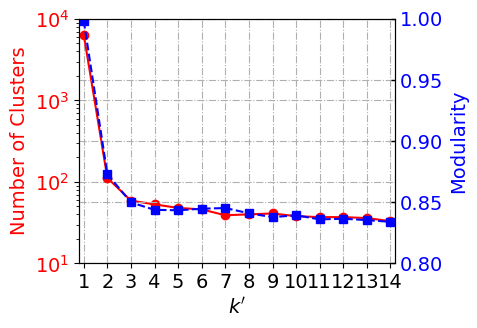

In [18]:
%matplotlib inline
plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: fig11(plt, ncs, mods),
                      figsize=(5, 3.5), fontsize=14)
plot.savefig('f3.eps', format='eps')
plot.show()

Generate the final k-nearest-neighbors graph with the selected $k=3$. Then run the Louvain algorithm on the graph and save a dataset with the best partition achieved with the detected clusters.

In [20]:
import time
start = time.time()

knn = KnnGraph(graph_path=None, k=4, graph_gen=True,
               embeddings=embeddings[embeddings.columns[:-1]].to_numpy(), 
               ips=embeddings.index, labels=embeddings['class'])
knn.fit_predict()
end = time.time()
print('程序执行时间: ',end - start)

程序执行时间:  297.8664195537567


In [21]:
pred = pd.DataFrame([(k, v) for k,v in knn.comms.items()], columns=['ip', 'C'])
pred = pred.set_index('ip').reindex(embeddings.index)
pred['class'] = embeddings['class']
pred = pred.reset_index()
pred.to_csv(f'{DATASETS}/detected_clusters_eu.csv.gz', index=False)
pred.head()

,ip,C,class
0,165.172.152.128,0,unknown
1,158.86.51.237,1,unknown
2,19.160.222.118,1,unknown
3,210.105.89.28,1,unknown
4,194.209.229.65,0,unknown


Compute the average silhouette for all the clusters ranking them

In [22]:
shs = get_shs_df(embeddings, pred.C.values).groupby('C').agg({'sh':'mean'})
shs = shs.sort_values('sh', ascending = False)
shs.reset_index().to_csv(f'{DATASETS}/sh_cluster_eu.csv', index = False)
shs.head()

,sh
C,
43,0.999784
90,0.986639
40,0.957368
82,0.952326
89,0.947454


In [45]:
import numpy as np
print(np.mean(shs['sh']))

0.2716213827779044


# <b>Cluster Inspection</b> <a name="ci"></a> 


At this point we manually inspect the found clusters. Firstly, we plot the trend of the clusters silhouette (cluster rank). Then, we focus on some of the best clusters and for each of them we generate a brief report, the activity patterns scatterplot and the heatmaps of the ports reached by the IPs belonging to the cluster.

In [23]:
lookup = pd.read_csv(f'{DATASETS}/detected_clusters_eu.csv.gz')
lookup.head()

,ip,C,class
0,165.172.152.128,0,unknown
1,158.86.51.237,1,unknown
2,19.160.222.118,1,unknown
3,210.105.89.28,1,unknown
4,194.209.229.65,0,unknown


In [5]:
with open(f'{DATASETS}/ips.json', 'r') as file:
    filters = json.loads(file.read())

### <b>Clusters Ranking</b> <a name="shplot"></a> 
[Back to Index](#toc)

Rank the clusters according to the average silhouette of the clusters points

In [28]:
shs = pd.read_csv(f'{DATASETS}/sh_cluster_eu.csv').set_index('C')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 640x480 with 0 Axes>

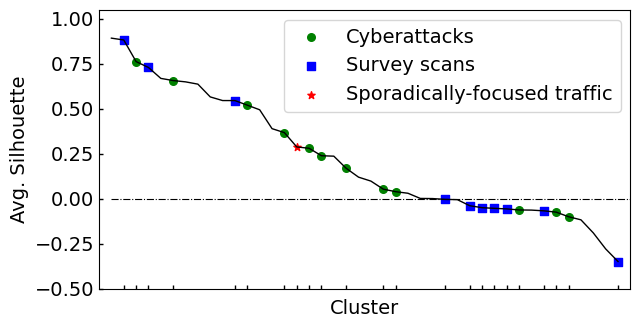

In [13]:
%matplotlib inline
plot = fastplot.plot(None, None, mode = 'callback', callback = lambda plt: fig12(plt, shs),
               cycler=cc, figsize=(6.5, 3.5), fontsize=14);
plot.savefig('f4.eps', format='eps')
plot.show()

## Swap the lines below to read the full dataset

In [29]:
# if demonstrative:
#     # this load roughly 6 days only
#     darknet = pd.read_csv(f'{DATASETS}/darknet.csv.gz', nrows=20000000)
# else:
#     # this will read the whole dataset - at least 32 GB of memory is required
#     darknet = pd.read_csv(f'{DATASETS}/darkbert_H.csv.gz') 

# darknet = darknet[darknet.ip.isin(filters['d30_f'])]

darknet = darknet.merge(lookup[['ip', 'C']], on='ip', how='left').dropna()
darknet['pkts'] = 1

In [30]:
darknet.head()

,ts,ip,port,proto,pp,class,C_x,pkts,C_y,C
0,2021-03-03 05:20:26.686132,165.172.152.128,445,TCP,445/TCP,unknown,0.0,1,0,0
1,2021-03-03 05:20:26.691946,158.86.51.237,16523,TCP,16523/TCP,unknown,1.0,1,1,1
2,2021-03-03 05:20:26.784749,19.160.222.118,5353,TCP,5353/TCP,unknown,1.0,1,1,1
3,2021-03-03 05:20:26.878851,210.105.89.28,7070,TCP,7070/TCP,unknown,2.0,1,1,1
4,2021-03-03 05:20:26.895800,194.209.229.65,445,TCP,445/TCP,unknown,0.0,1,0,0


In [ ]:
darknet[darknet['class'] == '1']['C'].unique()

KeyError: 'C'

### <b>Censys (Sub-clusters)</b> <a name="censysC"></a> 


In [11]:
def cluster_plot(c, save=False, fname=None):
    """Generate the cluster plots including the activity pattern and the port 
    pattern

    Parameters
    ----------
    c : str
        cluster identifier
    """
    clusters_ = darknet[darknet.C == c]
    C_ = clusters_.pivot_table(index = 'ip', columns = 'pp', values='pkts', aggfunc='sum')
    token__ = {v: k for k,v in enumerate(clusters_.ip.unique())}
    clusters_['tkn'] = clusters_.ip.apply(lambda x: token__[x])
    clusters_.index = pd.DatetimeIndex(clusters_.ts)
    #mpl.rcParams['axes.prop_cycle'] = cycler('color', cmap)
    
    %matplotlib inline
    plot = fastplot.plot(None, None, mode = 'callback', callback = lambda plt: plot_generic_pattern(plt, C_),
                   cycler=cc, figsize=(5, 3));
    if save==True:
        plt.savefig(f'{fname}_port.png', dpi=500)
    plot.show()

    %matplotlib inline
    plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: plot_port_pattern(plt, clusters_),
                          cycler=cc, figsize=(5, 3.5), fontsize=14)
    if save==True:
        plt.savefig(f'{fname}_act.png', dpi=500)
    plot.show()

In [19]:
censys = [16,  4, 13, 12, 15,  3,  9,  1, 11,  6, 10,  5, 26,  0, 18, 31,  2,
       14, 22, 28,  8, 19, 23, 27, 17, 38, 20, 24,  7, 35, 30, 29, 39, 34,
       36, 37, 32, 33, 25, 41]
extractions = [extract_cluster(darknet, c) for c in censys]
clusters = extractions[0][0]
    
clusters = extractions[0][0].append(extractions[1][0]).append(extractions[2][0])\
                            .append(extractions[3][0]).append(extractions[4][0])\
                            .append(extractions[5][0]).append(extractions[6][0])
    
clusters = clusters.sort_values('C')
token__ = {v: k for k,v in enumerate(clusters.ip.unique())}
clusters['tkn'] = clusters.ip.apply(lambda x: token__[x])
clusters.index = pd.DatetimeIndex(clusters.ts)

In [20]:
# New
cluster_report(clusters)   

,C,Senders,Port/Protocol,Top3 Ports
0,3,9834,1135,23/tcp(69.2)% 2323/tcp(6.3)% 445/tcp(3.7)%
1,4,7613,1174,1433/tcp(43.8)% 23/tcp(16.1)% 445/tcp(9.4)%
2,9,4751,646,23/tcp(30.8)% 445/tcp(14.9)% 80/tcp(6.2)%
3,12,9030,1120,445/tcp(77.6)% 23/tcp(8.2)% 80/tcp(1.6)%
4,13,3163,493,23/tcp(14.8)% 8081/tcp(6.4)% 80/tcp(6.4)%
5,15,5392,1158,80/tcp(22.9)% 8080/tcp(15.3)% 23/tcp(12.7)%
6,16,3278,325,23/tcp(24.5)% 445/tcp(9.4)% 21/tcp(6.7)%


<Figure size 640x480 with 0 Axes>

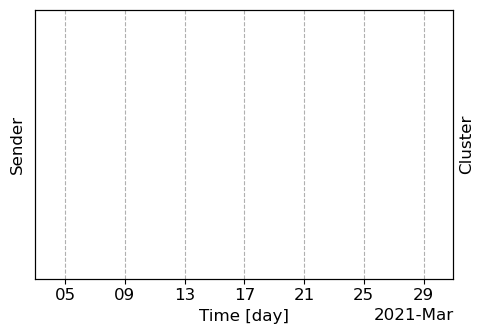

In [34]:
tick = manage_censys_ticks(clusters)
cmap = plt.cm.magma(np.linspace(0, 1,9))

%matplotlib inline
plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: fig13(plt, clusters, tick),
                      cycler=cycler('color', cmap), figsize=(5, 3.5), fontsize=12)
plot.show()

In [21]:
jaccs = []
sets = clusters.groupby('C').agg({'pp':set})
jacc = pd.DataFrame(columns=sets.index, index=sets.index)
for c1 in sets.index:
    for c2 in sets.index:
        jacc = update_jacc(jacc, c1, c2, sets)

for i in range(jacc.shape[0]):
    for j in range(i, jacc.shape[0]):
        if i!=j: jaccs.append(jacc.iloc[i, j])

upper_triangle = np.mean(jaccs)
diagonal = np.mean([jacc.iloc[i,i] for i in range(jacc.shape[0])])
print(f'Jaccard matrix Upper Triangle: {round(upper_triangle, 2)}')
print(f'Jaccard matrix Diagonal: {round(diagonal, 2)}')

Jaccard matrix Upper Triangle: 0.09
Jaccard matrix Diagonal: 1.0


<Figure size 640x480 with 0 Axes>

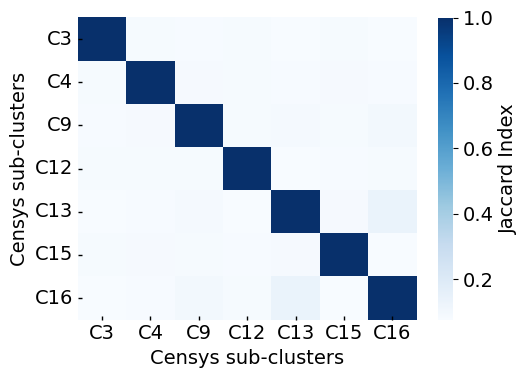

In [22]:
%matplotlib inline
plot = fastplot.plot(None, None, mode = 'callback', callback = lambda plt: plot_censys_jaccard(plt, jacc), 
                      figsize=(5.5, 4), fontsize=14);
plot.show()

### <b>Shadowserver (Discovered scanner)</b> <a name="ShadowserverC"></a> 


In [97]:
shadowserver = [25, 29, 37]

extractions = [extract_cluster(darknet, c) for c in shadowserver]
clusters = extractions[0][0]
    
clusters = extractions[0][0].append(extractions[1][0]).append(extractions[2][0])
token__ = {v: k for k,v in enumerate(clusters.ip.unique())}
clusters['tkn'] = clusters.ip.apply(lambda x: token__[x])
clusters.index = pd.DatetimeIndex(clusters.ts)

In [98]:
#new
cluster_report(clusters)

,C,Senders,Port/Protocol,Top3 Ports
0,25.0,61,47,623/UDP(9.9)% 123/UDP(9.9)% 523/UDP(9.9)%
1,29.0,36,42,5683/UDP(13.1)% 3389/UDP(12.0)% 443/TCP(3.1)%
2,37.0,16,41,111/UDP(32.3)% 137/UDP(30.5)% 449/TCP(1.5)%


<Figure size 640x480 with 0 Axes>

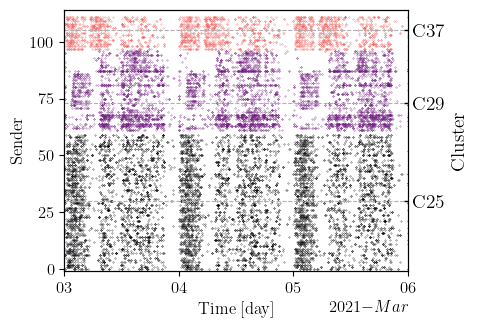

In [105]:
cmap = plt.cm.magma(np.linspace(0, 1,4))

%matplotlib inline
plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: fig14(plt, clusters),
                      cycler=cycler('color', cmap), figsize=(5, 3.5), fontsize=12)
plot.show()

### <b>Unknown8 (ADB Scanner)</b> <a name="new2"></a> 

<Figure size 640x480 with 0 Axes>

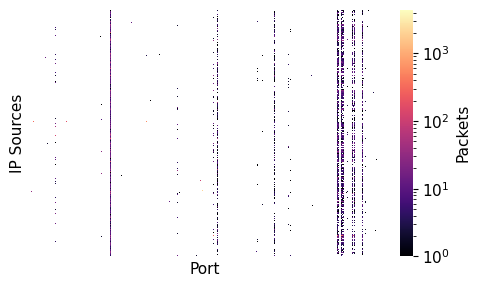

<Figure size 640x480 with 0 Axes>

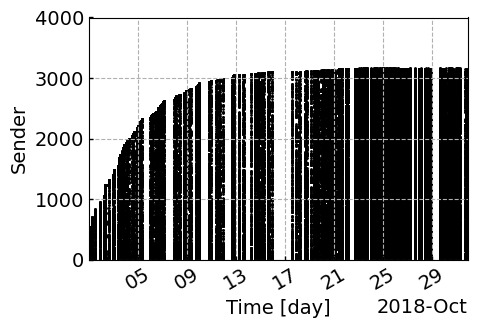

,C,Senders,Port/Protocol,Top3 Ports
0,13,3163,493,23/tcp(14.8)% 8081/tcp(6.4)% 80/tcp(6.4)%


In [44]:
clusters, _ = extract_cluster(darknet, 13)
cluster_plot(13, save=False, fname='adb')
cluster_report(clusters)

### <b>Unknown1 (NetBIOS scanner)</b> <a name="unk1"></a> 


<Figure size 640x480 with 0 Axes>

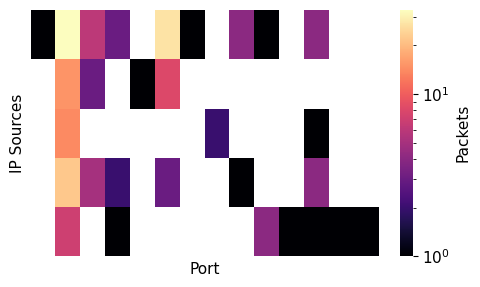

<Figure size 640x480 with 0 Axes>

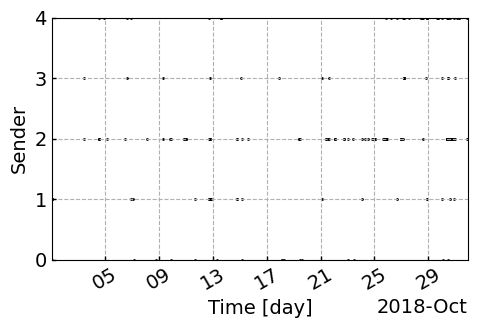

,C,Senders,Port/Protocol,Top3 Ports
0,40,5,14,23/tcp(51.4)% 445/tcp(21.5)% 2323/tcp(7.9)%


In [26]:
clusters, _ = extract_cluster(darknet, 40)
cluster_plot(40, save=False, fname='cogent_communication')
cluster_report(clusters)

### <b>Unknown2 (SMTP scanner)</b><a name="unk2"></a>


In [25]:
def cluster_plot(c, save=False, fname=None):
    """Generate the cluster plots including the activity pattern and the port 
    pattern

    Parameters
    ----------
    c : str
        cluster identifier
    """
    clusters_ = darknet[darknet.C == c]
    C_ = clusters_.pivot_table(index = 'ip', columns = 'pp', values='pkts', aggfunc='sum')
    token__ = {v: k for k,v in enumerate(clusters_.ip.unique())}
    clusters_['tkn'] = clusters_.ip.apply(lambda x: token__[x])
    clusters_.index = pd.DatetimeIndex(clusters_.ts)
    #mpl.rcParams['axes.prop_cycle'] = cycler('color', cmap)
    
    %matplotlib inline
    plot = fastplot.plot(None, None, mode = 'callback', callback = lambda plt: plot_generic_pattern(plt, C_),
                   cycler=cc, figsize=(5, 3));
    if save==True:
        # plot.savefig('f7.eps', format='eps')
        plot.savefig(f'f7.png')
    plot.show()

    %matplotlib inline
    plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: plot_port_pattern(plt, clusters_),
                          cycler=cc, figsize=(5, 3.5), fontsize=14)
    if save==True:
        # plot.savefig('f8.eps', format='eps')
        plot.savefig(f'f8.png')
    plot.show()

# no = 13
# clusters, _ = extract_cluster(darknet, no)
# cluster_plot(no, True)
# cluster_report(clusters)

In [27]:
darknet[darknet['class'] == 'unknown']['C'].unique()

array([ 0.,  3.,  4.,  5.,  6.,  7., 57.,  1.,  2., 13., 14., 10.,  8.,
       15., 16., 17., 18., 19., 21., 22., 23., 24., 27., 29., 30., 12.,
       31., 32., 26., 11., 47., 36., 38., 39., 40., 43., 56., 45., 46.,
       48., 41., 50., 52., 54.,  9., 51., 20., 53., 55., 28., 33., 34.,
       35., 37., 42., 44., 25., 58., 49.])

### <b>Unknown3 (SMB scanner)</b> <a name="unk3"></a> 


<Figure size 640x480 with 0 Axes>

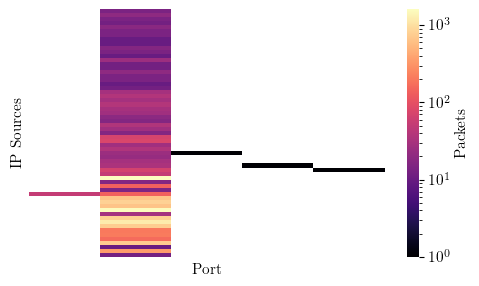

<Figure size 640x480 with 0 Axes>

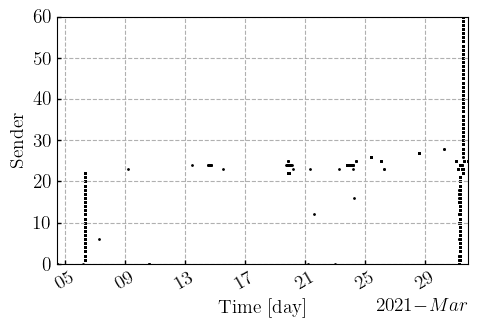

,C,Senders,Port/Protocol,Top3 Ports
0,13.0,61,5,445/TCP(99.5)% 445/OTH(0.5)% 64035/UDP(0.0)%


In [26]:
clusters, _ = extract_cluster(darknet, 13)
cluster_plot(13)
cluster_report(clusters)

### <b>Unknown4 (Mirai-like)</b> <a name="unk4"></a> 


In [34]:
darknet[darknet['class'] == 'unknown']['C'].unique()

array([ 0,  1,  2,  4,  5,  6,  8,  9, 10, 12,  3, 13, 14, 15, 16, 17, 18,
       19, 11, 21, 23,  7, 26, 27, 24, 30, 33, 35, 36, 37, 39, 41, 42, 43,
       46, 50, 34, 53, 54, 20, 47, 56, 55, 28, 22, 57, 59, 45, 25, 52, 60,
       29, 61, 62, 63, 64, 66, 68, 49, 69, 48, 72, 73, 38, 74, 70, 75, 44,
       31, 51, 76, 32, 77, 78, 79, 65, 67, 80, 81, 82, 83, 84, 85, 71, 87,
       88, 89, 86, 90, 40, 58], dtype=int64)

In [ ]:
import pandas as pd

# 显示所有列
pd.set_option('display.max_columns', None)
# 显示所有行
pd.set_option('display.max_rows', None)
# 设置 value 的显示长度为 100，默认为 50
pd.set_option('max_colwidth',100)

# no = 10
no = 6
# no = 29

clusters, _ = extract_cluster(darknet, no)
cluster_plot(no, save=True)
cluster_report(clusters)

<Figure size 640x480 with 0 Axes>

### <b>Unknown5 (SSH brute-force)</b> <a name="unk5"></a> 


<Figure size 640x480 with 0 Axes>

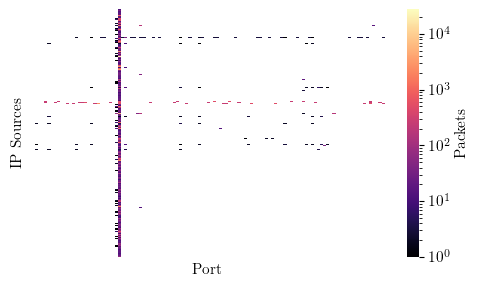

<Figure size 640x480 with 0 Axes>

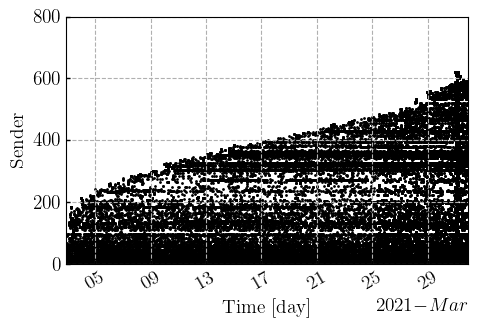

,C,Senders,Port/Protocol,Top3 Ports
0,26.0,623,116,22/TCP(87.7)% 5900/TCP(1.8)% 2000/TCP(0.9)%


In [28]:
clusters, _ = extract_cluster(darknet, 26)
cluster_plot(26)
cluster_report(clusters)

### <b>Unknown6 (Massive scanner)</b> <a name="unk6"></a> 


<Figure size 640x480 with 0 Axes>

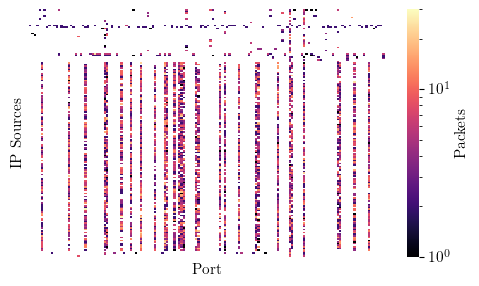

<Figure size 640x480 with 0 Axes>

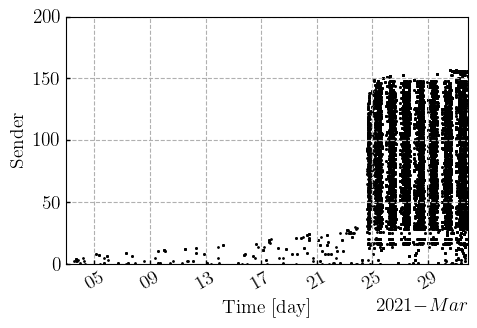

,C,Senders,Port/Protocol,Top3 Ports
0,31.0,158,148,443/TCP(5.4)% 3389/TCP(4.4)% 80/TCP(4.0)%


In [29]:
clusters, _ = extract_cluster(darknet, 31)
cluster_plot(31)
cluster_report(clusters)

### <b>Unknown 7</b> <a name="new"></a> 


<Figure size 640x480 with 0 Axes>

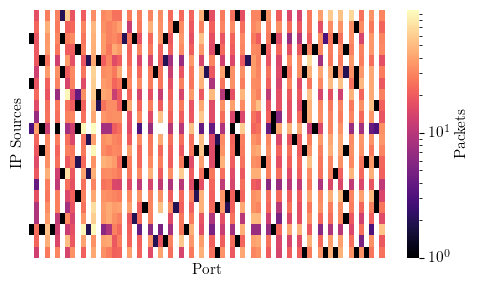

<Figure size 640x480 with 0 Axes>

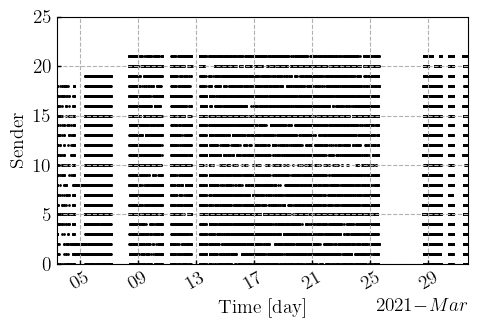

,C,Senders,Port/Protocol,Top3 Ports
0,45.0,22,69,161/UDP(5.2)% 443/TCP(3.5)% 80/TCP(3.4)%


In [37]:
clusters, _ = extract_cluster(darknet, 45)
cluster_plot(45)
cluster_report(clusters)

In [32]:
jaccs = []
sets = clusters.groupby('ip').agg({'pp':set})
jacc = pd.DataFrame(columns=sets.index, index=sets.index)
for c1 in sets.index:
    for c2 in sets.index:
        jacc = update_jacc(jacc, c1, c2, sets)

for i in range(jacc.shape[0]):
    for j in range(i, jacc.shape[0]):
        if i!=j: jaccs.append(jacc.iloc[i, j])

upper_triangle = np.mean(jaccs)
diagonal = np.mean([jacc.iloc[i,i] for i in range(jacc.shape[0])])
print(f'Jaccard matrix Upper Triangle: {round(upper_triangle, 2)}')
print(f'Jaccard matrix Diagonal: {round(diagonal, 2)}')

Jaccard matrix Upper Triangle: 0.82
Jaccard matrix Diagonal: 1.0
